In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import bs4
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import numpy as np
import os
from numba import jit

%matplotlib inline
sns.set(style="whitegrid")


In [2]:
# Download current premier league table
team_dict = {}

url = 'http://www.espnfc.com/barclays-premier-league/23/table'
r  = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser') 
# Note: html5lib deals better with broken html than lxml

for td in soup.findAll('td', { 'class' : 'pos' }):
    rank = int(td.text)
    res = [i.text for i in td.next_siblings if isinstance(i, bs4.element.Tag) and i.text!='\xa0']
    team_name = res[0].strip()
    
    values = []
    for i in res[1:]:
        a = i.replace(u'\xa0', '0')
        values.append(int(a))
    
    team_dict[team_name] = [rank] + values
  

team_df = pd.DataFrame.from_dict(team_dict, orient='index')
cols = ['Pos','P_ov','W_ov','D_ov','L_ov','F_ov','A_ov',
            'W_hm','D_hm','L_hm','F_hm','A_hm', 'W_aw',
            'D_aw','L_aw','F_aw','A_aw','GD','PTS']
team_df.columns = cols
team_df = team_df.sort_values('Pos')
team_df['team'] = team_df.index
team_df = team_df[['team']+cols]
team_df.head(5)


,team,Pos,P_ov,W_ov,D_ov,L_ov,F_ov,A_ov,W_hm,D_hm,L_hm,F_hm,A_hm,W_aw,D_aw,L_aw,F_aw,A_aw,GD,PTS
Manchester City,Manchester City,1,30,26,3,1,85,20,14,1,0,51,10,12,2,1,34,10,65,81
Manchester United,Manchester United,2,30,20,5,5,58,23,12,2,1,33,7,8,3,4,25,16,35,65
Tottenham Hotspur,Tottenham Hotspur,3,30,18,7,5,59,25,10,4,1,31,9,8,3,4,28,16,34,61
Liverpool,Liverpool,4,30,17,9,4,68,34,9,6,0,33,10,8,3,4,35,24,34,60
Chelsea,Chelsea,5,30,17,5,8,52,27,10,2,3,26,11,7,3,5,26,16,25,56


In [3]:
# Download players from the FPL site's resource API
url = "https://fantasy.premierleague.com/drf/bootstrap-static"
r  = requests.get(url)
data = json.loads(r.text)

all_players = data['elements']

CE = data['current-event']
NE = data['next-event']
GW = CE

player_dict = {}
position_dict = {}
cost_dict = {}
status_dict = {}
for i in all_players:
    player_dict[i['id']] = i['web_name']
    position_dict[i['id']] = i['element_type']
    cost_dict[i['id']] = i['now_cost']
    status_dict[i['id']] = i['status']
   

# Download player history
history_dict = {};
current_dict = {};
for i in player_dict: 
    url = "https://fantasy.premierleague.com/drf/element-summary/" + str(i)
    r  = requests.get(url)
    data = json.loads(r.text)
    # data['fixtures']
    history = data['history']
    history_past = data['history_past']
   
    # Dataset with total_points per historic season and calculated average points per season
    points_seasons = np.zeros((12,), dtype=np.int)
    for season in history_past:
        points_seasons[season['season']] = int(season['total_points']) 
   
    history_dict[i] = points_seasons
    
        

    # Dataset with points for current season
    points_this = np.zeros((GW+1,), dtype=np.int)
    for game in history:
        points_this[int(game['round'])-1] = int(game['total_points'])
    
    current_dict[i] = points_this
        
print("Player data downloaded..")
        

Player data downloaded..


In [4]:
# GameWeek
GW

30

In [5]:
# Next GameWeek
NE

31

In [6]:
df = pd.DataFrame.from_dict(history_dict, orient='index')
cols = ['2005/06', '2006/07', '2007/08', '2008/09', '2009/10', '2010/11',
           '2011/12', '2012/13', '2013/14', '2014/15', '2015/16', '2016/17']
df.columns = cols
df.insert(0, 'Name', player_dict.values())
df.insert(1, 'Position', position_dict.values())
df.insert(2, "Cost", cost_dict.values())
df.insert(3, "Status", status_dict.values())
df = df.replace(0, np.NaN)
df2 = df[['2015/16','2016/17']]
df['avg2yr'] = df2.mean(axis=1)
df['cost-pt'] = df['Cost']/df['avg2yr']
df = df.sort_values('2016/17', axis=0, ascending=False)
df.drop(['2005/06','2006/07'], axis=1, inplace=True)
df[df['Name']=='Davies']

,Name,Position,Cost,Status,2007/08,2008/09,2009/10,2010/11,2011/12,2012/13,2013/14,2014/15,2015/16,2016/17,avg2yr,cost-pt
381,Davies,2,59,a,NaN,NaN,NaN,NaN,NaN,99.0,99.0,31.0,52.0,90.0,71.0,0.830986
156,Davies,3,51,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,63.0,33.5,1.522388


In [7]:
df1 = pd.DataFrame.from_dict(current_dict, orient='index')
cols = list(range(1,GW+2))
df1.columns = cols
df1.head(5)

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,3,2,6,10,6,6,1,1,2,...,2,2,3,1,2,4,1,2,15,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,6,7,6,0,2,0,2,...,0,0,10,1,7,2,1,1,0,0
5,0,0,0,0,0,0,0,9,1,2,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df1.insert(0, 'Name', player_dict.values())
df1.insert(1, 'Position', position_dict.values())
df1.insert(2, "Cost", cost_dict.values())
df1.insert(3, "Total_Points", df1[list(range(1,GW+2))].sum(axis=1))
df1.insert(4, "Points_Cost", df1["Total_Points"]/df1["Cost"])
df1.insert(5, "Points_Fixture", df1["Total_Points"]/GW)
df1.insert(6, "Status", status_dict.values())
#df1 = df1.replace(0, np.NaN)
df1 = df1.sort_values(['Position','Points_Cost'], axis=0, ascending=False)

df1.head(20)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,22,23,24,25,26,27,28,29,30,31
373,Jordan Ayew,4,54,91,1.685185,3.033333,s,2,2,6,...,2,8,2,8,2,2,2,7,-2,0
71,Murray,4,59,99,1.677966,3.300000,a,1,2,0,...,8,2,1,8,6,2,12,7,2,0
235,Firmino,4,95,156,1.642105,5.200000,a,12,2,12,...,1,8,2,8,2,12,8,5,2,0
209,Vardy,4,87,135,1.551724,4.500000,a,13,2,2,...,0,2,9,7,6,5,2,2,5,0
159,Calvert-Lewin,4,50,77,1.540000,2.566667,a,5,5,1,...,1,1,0,1,5,0,1,1,1,0
187,Depoitre,4,51,78,1.529412,2.600000,a,0,0,0,...,1,2,1,2,2,0,1,1,1,0
348,Diouf,4,52,77,1.480769,2.566667,i,2,2,0,...,1,1,7,1,1,2,1,1,0,0
548,Niasse,4,49,72,1.469388,2.400000,a,0,0,0,...,2,0,7,2,2,12,1,1,0,0
257,Agüero,4,118,169,1.432203,5.633333,d,9,2,1,...,6,5,17,6,2,21,5,2,0,0
161,Rooney,4,72,102,1.416667,3.400000,a,9,8,1,...,1,1,1,2,0,2,2,1,0,0


In [9]:
#Attackers
df1_attack = df1[df1['Position']==4]
df1_attack.sort_values(['Points_Fixture', 'Cost'], axis=0, ascending=False).head(10)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,22,23,24,25,26,27,28,29,30,31
394,Kane,4,128,178,1.390625,5.933333,d,1,1,2,...,2,13,8,2,4,6,6,5,1,0
257,Agüero,4,118,169,1.432203,5.633333,d,9,2,1,...,6,5,17,6,2,21,5,2,0,0
235,Firmino,4,95,156,1.642105,5.200000,a,12,2,12,...,1,8,2,8,2,12,8,5,2,0
285,Lukaku,4,112,144,1.285714,4.800000,a,13,6,0,...,0,5,5,2,6,2,12,8,5,0
209,Vardy,4,87,135,1.551724,4.500000,a,13,2,2,...,0,2,9,7,6,5,2,2,5,0
472,Morata,4,104,103,0.990385,3.433333,a,10,2,12,...,2,1,0,0,0,4,1,1,0,0
161,Rooney,4,72,102,1.416667,3.400000,a,9,8,1,...,1,1,1,2,0,2,2,1,0,0
28,Lacazette,4,102,99,0.970588,3.300000,i,6,2,1,...,2,2,8,2,0,1,0,0,0,0
71,Murray,4,59,99,1.677966,3.300000,a,1,2,0,...,8,2,1,8,6,2,12,7,2,0
373,Jordan Ayew,4,54,91,1.685185,3.033333,s,2,2,6,...,2,8,2,8,2,2,2,7,-2,0


In [10]:
#Goalies
df1_gk = df1[df1['Position']==1]
df1_gk.sort_values(['Points_Fixture', 'Cost'], axis=0, ascending=False).head(10)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,22,23,24,25,26,27,28,29,30,31
260,de Gea,1,59,144,2.440678,4.800000,a,6,6,7,...,6,7,6,2,6,2,4,1,2,0
240,Ederson,1,56,138,2.464286,4.600000,a,6,2,2,...,3,1,3,6,2,2,15,6,7,0
469,Pope,1,49,131,2.673469,4.366667,a,0,0,0,...,2,2,2,11,5,3,3,3,9,0
350,Fabianski,1,47,123,2.617021,4.100000,a,6,1,7,...,2,3,8,3,3,6,0,2,9,0
54,Ryan,1,45,115,2.555556,3.833333,a,2,1,6,...,3,1,2,2,2,8,2,4,7,0
94,Courtois,1,54,113,2.092593,3.766667,a,1,6,6,...,1,6,0,1,1,6,2,2,2,0
2,Cech,1,53,112,2.113208,3.733333,a,1,3,2,...,2,2,3,1,2,4,1,2,15,0
135,Pickford,1,49,111,2.265306,3.700000,a,6,4,2,...,2,2,3,2,0,3,3,3,7,0
163,Lössl,1,46,110,2.391304,3.666667,a,9,8,6,...,1,0,2,2,10,2,2,2,6,0
375,Lloris,1,54,107,1.981481,3.566667,a,7,1,2,...,2,6,0,7,1,6,7,7,2,0


In [11]:
#Defs
df1_def = df1[df1['Position']==2]
df1_def.sort_values(['Points_Fixture', 'Cost'], axis=0, ascending=False).head(10)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,22,23,24,25,26,27,28,29,30,31
100,Alonso,2,72,143,1.986111,4.766667,a,0,16,6,...,7,8,6,1,0,0,1,2,2,0
97,Azpilicueta,2,69,142,2.057971,4.733333,a,1,2,9,...,1,7,6,1,0,8,1,2,3,0
245,Otamendi,2,64,142,2.218750,4.733333,a,8,2,1,...,2,-1,2,6,2,2,5,6,8,0
267,Valencia,2,69,128,1.855072,4.266667,a,5,6,9,...,0,15,5,1,6,1,1,4,1,0
379,Walker,2,66,124,1.878788,4.133333,a,6,-2,0,...,2,3,2,6,2,2,10,6,6,0
381,Davies,2,59,119,2.016949,3.966667,a,14,2,2,...,2,6,8,6,1,12,7,6,0,0
10,Monreal,2,55,112,2.036364,3.733333,d,1,2,0,...,0,0,16,8,1,2,0,0,0,0
380,Vertonghen,2,60,103,1.716667,3.433333,a,6,0,2,...,2,6,2,7,1,8,0,8,2,0
198,Maguire,2,56,102,1.821429,3.400000,a,3,15,1,...,6,6,8,1,2,-1,2,2,2,0
7,Bellerín,2,59,101,1.711864,3.366667,d,1,2,0,...,8,8,2,0,2,2,1,1,0,0


In [12]:
#Mids
df1_mid = df1[df1['Position']==3]
df1_mid.sort_values(['Points_Fixture', 'Cost'], axis=0, ascending=False).head(10)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,22,23,24,25,26,27,28,29,30,31
234,Salah,3,106,237,2.235849,7.900000,a,11,1,11,...,0,11,2,8,15,13,10,8,2,0
252,De Bruyne,3,104,183,1.759615,6.100000,a,3,2,3,...,12,2,6,14,2,13,3,3,3,0
247,Sterling,3,86,179,2.081395,5.966667,a,0,6,4,...,9,1,5,10,3,8,0,0,6,0
199,Mahrez,3,88,161,1.829545,5.366667,a,5,11,2,...,14,3,8,0,0,1,2,10,11,0
390,Son,3,82,151,1.841463,5.033333,a,1,1,3,...,9,13,2,3,2,3,1,16,15,0
104,Hazard,3,106,149,1.405660,4.966667,a,0,0,0,...,10,1,16,2,8,16,6,2,3,0
387,Eriksen,3,94,147,1.563830,4.900000,a,12,7,3,...,2,9,0,10,2,3,6,3,5,0
248,David Silva,3,80,141,1.762500,4.700000,a,8,2,6,...,1,0,2,0,0,0,8,9,16,0
255,Sané,3,86,137,1.593023,4.566667,a,1,2,1,...,5,7,5,0,0,0,13,3,3,0
70,Groß,3,60,135,2.250000,4.500000,a,2,2,3,...,2,2,2,2,13,2,5,6,2,0


In [15]:
# Zero scores where no data
g = df1_gk.fillna(0)
d = df1_def.fillna(0)
m = df1_mid.fillna(0)
a = df1_attack.fillna(0)

# Last 6 match rolling average
r6 = list(range(GW-5, GW+1))
g['PFA6'] = g[r6].sum(axis=1)/6
d['PFA6'] = d[r6].sum(axis=1)/6
m['PFA6'] = m[r6].sum(axis=1)/6
a['PFA6'] = a[r6].sum(axis=1)/6
df1['PFA6'] = df1[r6].sum(axis=1)/6

In [17]:
# Team constellation
MAX_NGK = 2
MAX_NDEF = 5
MAX_NMID = 5
MAX_NFWD = 3

#High Ownership Players

# Otamendi (245), Alonso, Davies
HO_DEF = np.array([381, 245])

# Salah, Sterling 247
HO_MID = np.array([234])

# Kane, (Firmino is 235), (Augero 257)
# Kane is injured :(
HO_FWD = np.array([257, 235])

In [18]:
# Only pick from performing players who are not earmarked as High Ownership (HO)
np1_gk_f = g[(g['PFA6'] > np.percentile(g['PFA6'],70))].index.values
np1_def_f = d[(d['PFA6'] > np.percentile(d['PFA6'],75))].drop(HO_DEF).index.values
np1_mid_f = m[(m['PFA6'] > np.percentile(m['PFA6'],75))].drop(HO_MID).index.values
np1_fwd_f = a[(a['PFA6'] > np.percentile(a['PFA6'],80))].drop(HO_FWD).index.values


In [19]:
# How many players to pick in each position
pdef = MAX_NDEF - len(HO_DEF)
pmid = MAX_NMID - len(HO_MID)
pfwd = MAX_NFWD - len(HO_FWD)

In [20]:
# Max team budget
MAX_COST = 1015

In [21]:
# Department of Brute force

MAX_EPOCHS = 2000000
INTERVAL = MAX_EPOCHS // 100

epoch = 0
max_score = 60
max_tm = df1.sample(n=15)

def TimestampMillisec64():
    return int((datetime.datetime.utcnow() - datetime.datetime(1970, 1, 1)).total_seconds() * 1000) 

@jit(nopython=True, cache=True)
def pick_n(n, arr):
    rnd = np.random.choice(arr, n, replace=False)
    return rnd

@jit(nopython=True, cache=True)
def build_team(gks, defs, mids, mfwd):
    tm = np.concatenate((HO_DEF,defs,HO_MID,mids,HO_FWD,mfwd,gks))
    return tm

t1 = TimestampMillisec64()
while (epoch < MAX_EPOCHS):
    epoch = epoch + 1
    if epoch%INTERVAL == 0:
        t2 = TimestampMillisec64()
        print("Time %d, Epoch %d .." % (round((t2-t1)/1000), epoch))
        t1 = t2
     
    tm = build_team(pick_n(MAX_NGK, np1_gk_f),
                    pick_n(pdef, np1_def_f),
                    pick_n(pmid, np1_mid_f),
                    pick_n(pfwd, np1_fwd_f)
                   )
    
    pd_max_tm = df1.loc[tm]
    tm_cost = pd_max_tm.sum(axis=0)['Cost']
    tm_score = pd_max_tm.sum(axis=0)['PFA6'] 
            
    if ((tm_score > max_score) and (tm_cost < MAX_COST)):
        max_score = tm_score
        fname = os.path.join('output', 'NE29_1015_Team_Agg_%d_PFA6_%d.csv' % (max_score, TimestampMillisec64()))
        pd_max_tm.to_csv(path_or_buf=fname)
        print("Epoch: %d, PFA6: %d, Cost: %d" % (epoch, tm_score, tm_cost))
                

Epoch: 3, PFA6: 70, Cost: 989
Epoch: 8, PFA6: 72, Cost: 1003
Epoch: 53, PFA6: 74, Cost: 996
Epoch: 83, PFA6: 74, Cost: 1012
Epoch: 153, PFA6: 76, Cost: 989
Epoch: 283, PFA6: 76, Cost: 965
Epoch: 690, PFA6: 77, Cost: 998
Epoch: 745, PFA6: 78, Cost: 985
Epoch: 2903, PFA6: 79, Cost: 1013
Time 21, Epoch 20000 ..
Time 20, Epoch 40000 ..
Epoch: 56459, PFA6: 80, Cost: 998
Time 20, Epoch 60000 ..
Epoch: 64648, PFA6: 81, Cost: 1010
Time 22, Epoch 80000 ..
Epoch: 86867, PFA6: 81, Cost: 998
Time 20, Epoch 100000 ..
Epoch: 115865, PFA6: 82, Cost: 1003
Time 20, Epoch 120000 ..
Time 20, Epoch 140000 ..
Time 20, Epoch 160000 ..
Time 20, Epoch 180000 ..
Time 20, Epoch 200000 ..
Time 20, Epoch 220000 ..
Time 20, Epoch 240000 ..
Time 20, Epoch 260000 ..
Time 20, Epoch 280000 ..
Epoch: 287151, PFA6: 82, Cost: 1011
Time 20, Epoch 300000 ..
Time 20, Epoch 320000 ..
Time 20, Epoch 340000 ..
Time 20, Epoch 360000 ..
Time 20, Epoch 380000 ..
Epoch: 394303, PFA6: 83, Cost: 968
Time 20, Epoch 400000 ..
Time 20,

In [415]:
%%timeit
pick_n(pmid, np1_mid_f)

477 ns ± 1.41 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [363]:
%%timeit
build_team(pick_n(MAX_NGK, np1_gk_f),
           pick_n(pdef, np1_def_f),
           pick_n(pmid, np1_mid_f),
           pick_n(pfwd, np1_fwd_f)
          )

2.97 µs ± 10.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [298]:
pd_max_tm.sum(axis=0)['Cost']

1098

In [300]:
pd_max_tm.sort_values(['Position', 'PFA6', 'Cost'], axis=0, ascending=False)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,16,17,18,19,20,21,22,23,24,PFA6
394,Kane,4,130,146,1.123077,8.588235,a,1,1,2,...,12,2,1,17,17,0,2,13,0,8.333333
235,Firmino,4,91,117,1.285714,6.882353,a,12,2,12,...,1,2,12,11,13,2,1,8,0,7.833333
373,Ayew,4,51,70,1.372549,4.117647,a,2,2,6,...,1,2,1,8,2,7,2,8,0,4.666667
234,Salah,3,101,179,1.772277,10.529412,a,11,1,11,...,11,3,8,10,9,14,0,11,0,8.666667
247,Sterling,3,89,147,1.651685,8.647059,a,0,6,4,...,2,9,12,13,11,1,9,1,0,7.833333
199,Mahrez,3,86,129,1.500000,7.588235,a,5,11,2,...,9,8,2,5,8,5,14,3,0,6.166667
252,De Bruyne,3,102,139,1.362745,8.176471,a,3,2,3,...,2,10,10,3,6,3,12,2,0,6.000000
414,Doucouré,3,53,95,1.792453,5.588235,a,9,3,3,...,2,2,7,0,5,1,2,9,0,4.000000
100,Alonso,2,73,131,1.794521,7.705882,a,0,16,6,...,0,6,14,6,14,6,7,8,0,9.166667
245,Otamendi,2,65,111,1.707692,6.529412,a,8,2,1,...,11,6,1,7,8,8,2,-1,0,4.166667


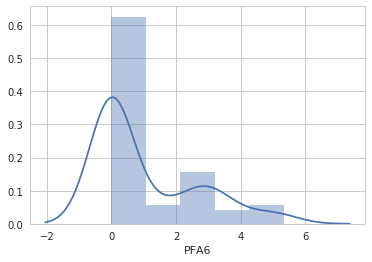

In [303]:
sns.distplot(g['PFA6'])

In [304]:
np.percentile(g['PFA6'],80)

2.8333333333333335

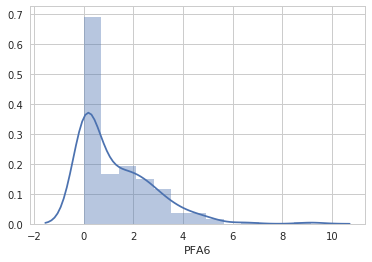

In [305]:
sns.distplot(d['PFA6'])

In [306]:
np.percentile(d['PFA6'],95)

4.0333333333333314

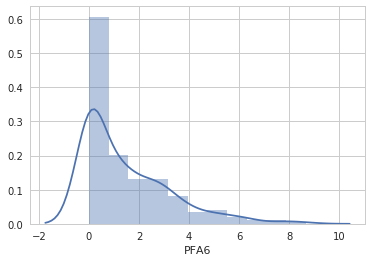

In [307]:
sns.distplot(m['PFA6'])

In [308]:
np.percentile(m['PFA6'],95)

5.0666666666666629

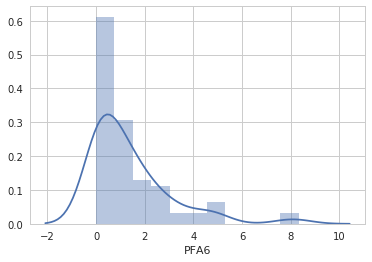

In [309]:
sns.distplot(a['PFA6'])

In [310]:
np.percentile(a['PFA6'],95)

4.666666666666667

In [311]:
attributes = ['Points_Cost','Points_Fixture', 'PFA6']

data_attributes = a[attributes]

data_attributes.head()

,Points_Cost,Points_Fixture,PFA6
373,1.372549,4.117647,4.666667
235,1.285714,6.882353,7.833333
187,1.272727,4.117647,4.666667
161,1.253333,5.529412,2.666667
159,1.236364,4.000000,2.000000


In [312]:
from sklearn.cluster import KMeans
from sklearn import metrics

# Create silhouette score dictionary
s_score_dict = {}
for i in range(2,11):
    km = KMeans(n_clusters=i, random_state=1)
    l = km.fit_predict(data_attributes)
    s_s = metrics.silhouette_score(data_attributes, l)
    s_score_dict[i] = [s_s]

# Print out `s_score_dict`
print(s_score_dict)

{2: [0.53395239660382943], 3: [0.53947549024959995], 4: [0.51124320267135925], 5: [0.5006202416221357], 6: [0.49962716968016058], 7: [0.50252860325323301], 8: [0.51645336848634349], 9: [0.51450802491744008], 10: [0.51665883304268334]}


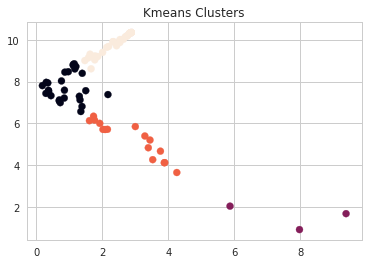

In [313]:
# Create K-means model and determine euclidian distances for each data point
kmeans_model = KMeans(n_clusters=4, random_state=1)
distances = kmeans_model.fit_transform(data_attributes)

# Create scatter plot using labels from K-means model as color
labels = kmeans_model.labels_

plt.scatter(distances[:,0], distances[:,1], c=labels)
plt.title('Kmeans Clusters')

plt.show()

In [314]:
# Add labels from K-means model to `df` DataFrame and attributes list
a['labels'] = labels
attributes.append('labels')

In [315]:
a[a['labels']==3].head(20)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,17,18,19,20,21,22,23,24,PFA6,labels
239,Solanke,4,47,20,0.425532,1.176471,a,0,1,0,...,1,1,0,1,0,2,0,0,0.666667,3
372,McBurnie,4,45,16,0.355556,0.941176,a,1,1,1,...,0,0,0,2,4,1,2,0,1.500000,3
236,Sturridge,4,79,25,0.316456,1.470588,d,0,2,5,...,0,0,0,0,0,0,0,0,0.000000,3
349,Berahino,4,56,15,0.267857,0.882353,a,2,5,0,...,0,1,0,0,2,1,0,0,0.666667,3
418,Okaka,4,53,14,0.264151,0.823529,a,7,0,0,...,0,1,1,1,2,0,1,0,1.000000,3
113,Batshuayi,4,81,20,0.246914,1.176471,a,1,-1,1,...,1,0,1,1,1,0,0,0,0.500000,3
50,Mousset,4,49,11,0.224490,0.647059,a,0,1,1,...,0,0,1,0,1,1,1,0,0.666667,3
457,Carroll,4,58,13,0.224138,0.764706,d,0,0,0,...,0,0,4,1,0,0,0,0,0.833333,3
303,Mitrovic,4,47,10,0.212766,0.588235,i,0,0,5,...,0,0,0,0,0,0,0,0,0.000000,3
258,Iheanacho,4,65,10,0.153846,0.588235,a,1,0,0,...,0,0,0,0,0,0,0,0,0.000000,3


In [316]:
a[a['labels']==2].head(20)

,Name,Position,Cost,Total_Points,Points_Cost,Points_Fixture,Status,1,2,3,...,17,18,19,20,21,22,23,24,PFA6,labels
373,Ayew,4,51,70,1.372549,4.117647,a,2,2,6,...,2,1,8,2,7,2,8,0,4.666667,2
187,Depoitre,4,55,70,1.272727,4.117647,a,0,0,0,...,5,13,9,1,2,1,2,0,4.666667,2
161,Rooney,4,75,94,1.253333,5.529412,a,9,8,1,...,8,13,0,0,1,1,1,0,2.666667,2
159,Calvert-Lewin,4,55,68,1.236364,4.000000,a,5,5,1,...,1,6,1,2,1,1,1,0,2.000000,2
209,Vardy,4,85,99,1.164706,5.823529,a,13,2,2,...,5,2,8,2,9,0,2,0,3.833333,2
488,Joselu,4,55,59,1.072727,3.470588,a,0,0,7,...,1,2,5,2,2,0,7,0,3.000000,2
71,Murray,4,57,61,1.070175,3.588235,a,1,2,0,...,1,0,1,1,2,8,2,0,2.333333,2
437,Rodriguez,4,55,56,1.018182,3.294118,a,1,2,5,...,1,1,1,2,8,2,5,0,3.166667,2
48,Wilson,4,57,57,1.000000,3.352941,a,0,0,0,...,2,0,2,7,2,6,12,0,4.833333,2
302,Pérez,4,52,52,1.000000,3.058824,a,2,2,5,...,1,2,1,0,1,9,5,0,3.000000,2
